<a href="https://www.kaggle.com/code/sheemamasood/bird-clef-2025-eda?scriptVersionId=245829194" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Audio Data Processing and EDA

In this notebook, we will start by converting the audio data into spectrograms. Spectrograms provide a visual representation of the frequency spectrum of the audio signal over time. This transformation allows us to capture the patterns and features within the audio recordings that are crucial for classifying the species based on their calls. By converting the audio files into spectrograms and saving them in the NPZ format, we ensure that the data is stored efficiently for subsequent training.

After processing the audio data, we will perform **Exploratory Data Analysis (EDA)**. This step is important to:

- Understand the distribution of species across the dataset.
- Analyze the quality of the recordings.
- Investigate the relationships between various metadata attributes (e.g., location, rating, etc.).

By performing EDA, we can identify any data imbalances, noisy recordings, or other factors that might affect model performance. This will help us prepare the data more effectively for the training phase.

------------

## 🔗 BirdCLEF 2025 - Project Notebook Links

Here are the different stages of my BirdCLEF 2025 pipeline, organized by functionality:

### 📊 Data Preparation
- [BirdCLEF 2025 - Data Preparation](https://www.kaggle.com/code/sheemamasood/birdclef-2025-data-prepartion)

### 🎛️ Mel Spectrogram Generation
- [BirdCLEF 2025 - Mel Generation](https://www.kaggle.com/code/sheemamasood/birdclef2025-mel-generation)

### 🏷️ Pseudo Labelling for SSL
- [BirdCLEF 2025 - Pseudo Labelling for SSL](https://www.kaggle.com/code/sheemamasood/birdclef2025-psedolabelling-for-ssl)

### 🧠 Model Training
- [BirdCLEF 2025 - Model Training (Phase 1)](https://www.kaggle.com/code/sheemamasood/birdclef2025-model-training-phase1)

### 📦 Inference & Submissions
- [BirdCLEF 2025 - Submissions](https://www.kaggle.com/code/sheemamasood/birdclef2025-submissions)


In [1]:
# Basic utilities
import os
import math
import time
import random
import gc
import logging
import warnings
from pathlib import Path
import librosa.display
import matplotlib.pyplot as plt
# Data handling

import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

# Audio processing
import librosa

# Visualization
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm  # for progress bars


### Configurations:

In [2]:
class Config:
    # Define paths for the dataset
    OUTPUT_DIR = '/kaggle/working/'
    DATA_ROOT = '/kaggle/input/birdclef-2025'  # Path to the dataset

    # Audio settings
    FS = 32000  # Sampling rate (audio)

    # Mel spectrogram parameters (for converting audio to image)
    N_FFT = 1024       # FFT window size
    HOP_LENGTH = 512   # Step size for each frame
    N_MELS = 128       # Number of mel bands
    FMIN = 50          # Minimum Mel frequency
    FMAX = 14000       # Maximum Mel frequency

    # Parameters for audio duration and spectrogram size
    TARGET_DURATION = 5.0  # Length of each audio (in seconds)
    TARGET_SHAPE = (256, 256)  # Size of the spectrogram image

    # No limit on the number of samples during training (full dataset)
    N_MAX = None  

    # flag for training mode
    TRAINING_MODE = True  
    
    # Additional training-specific configurations
    EPOCHS = 10  
    BATCH_SIZE = 32  
    LEARNING_RATE = 0.001  

# Create the config object
config = Config()



## Loading Data

In [3]:
# Load taxonomy data (bird species details)
taxonomy_df = pd.read_csv(f'{config.DATA_ROOT}/taxonomy.csv')
print("taxonomy data loaded")

# Create mapping from bird ID to class name
species_class_map = dict(zip(taxonomy_df['primary_label'], taxonomy_df['class_name']))

# Load training metadata
train_df = pd.read_csv(f'{config.DATA_ROOT}/train.csv')
print("training metadata loaded ")

taxonomy data loaded
training metadata loaded 


### Basic Statistical EDA

In [4]:
print("="*40)
print(f"📦 Train Data Shape: {train_df.shape}")
print(f"📚 Taxonomy Data Shape: {taxonomy_df.shape}")
print("="*40)

### 🔹 1. Columns in Each File
print("\n🔍 Columns in Train Data:", train_df.columns.tolist())
print("🔍 Columns in Taxonomy Data:", taxonomy_df.columns.tolist())

### 🔹 2. Data Types
print("\n📊 Train Data Types:")
print(train_df.info())

print("\n📊 Taxonomy Data Types:")
print(taxonomy_df.info())

### 🔹 3. Basic Descriptive Statistics
print("\n📈 Basic Stats - Train Data")
display(train_df.describe(include='all').T)  # works well in Jupyter

print("\n📈 Basic Stats - Taxonomy Data")
display(taxonomy_df.describe(include='all').T)

### 🔹 4. Missing Values Check
print("\n❌ Missing Values in Train Data:")
print(train_df.isnull().sum())

print("\n❌ Missing Values in Taxonomy Data:")
print(taxonomy_df.isnull().sum())

### 🔹 5. Random Sample Rows for Quick Glance
print("\n🔹 Sample Rows from Train Data:")
display(train_df.sample(5))

print("\n🔹 Sample Rows from Taxonomy Data:")
display(taxonomy_df.sample(5))


📦 Train Data Shape: (28564, 13)
📚 Taxonomy Data Shape: (206, 5)

🔍 Columns in Train Data: ['primary_label', 'secondary_labels', 'type', 'filename', 'collection', 'rating', 'url', 'latitude', 'longitude', 'scientific_name', 'common_name', 'author', 'license']
🔍 Columns in Taxonomy Data: ['primary_label', 'inat_taxon_id', 'scientific_name', 'common_name', 'class_name']

📊 Train Data Types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28564 entries, 0 to 28563
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   primary_label     28564 non-null  object 
 1   secondary_labels  28564 non-null  object 
 2   type              28564 non-null  object 
 3   filename          28564 non-null  object 
 4   collection        28564 non-null  object 
 5   rating            28564 non-null  float64
 6   url               28564 non-null  object 
 7   latitude          27755 non-null  float64
 8   longitude         27755 n

count unique  \
primary_label       28564    206   
secondary_labels    28564    745   
type                28564    736   
filename            28564  28564   
collection          28564      3   
rating            28564.0    NaN   
url                 28564  28552   
latitude          27755.0    NaN   
longitude         27755.0    NaN   
scientific_name     28564    206   
common_name         28564    206   
author              28564   2493   
license             28564      8   

                                                                top   freq  \
primary_label                                                grekis    990   
secondary_labels                                               ['']  25885   
type                                                       ['song']   9437   
filename                                       1139490/CSA36385.ogg      1   
collection                                                       XC  21204   
rating                                                          NaN    NaN   
url               https://static.inaturalist.org/sounds/1020465.wav      4   
latitude                                                        NaN    NaN   
longitude                                                       NaN    NaN   
scientific_name                                Pitangus sulphuratus    990   
common_name                                          Great Kiskadee    990   
author                                   JAYRSON ARAUJO DE OLIVEIRA   1780   
license                                             cc-by-nc-sa 4.0  16813   

                      mean        std      min      25%      50%      75%  \
primary_label          NaN        NaN      NaN      NaN      NaN      NaN   
secondary_labels       NaN        NaN      NaN      NaN      NaN      NaN   
type                   NaN        NaN      NaN      NaN      NaN      NaN   
filename               NaN        NaN      NaN      NaN      NaN      NaN   
collection             NaN        NaN      NaN      NaN      NaN      NaN   
rating            2.917063   1.964896      0.0      0.0      4.0      4.5   
url                    NaN        NaN      NaN      NaN      NaN      NaN   
latitude          -0.53348  17.609276 -54.8574 -15.0846   1.1316    9.511   
longitude        -68.52438  21.614566  -163.68 -79.6492 -73.4954 -53.8018   
scientific_name        NaN        NaN      NaN      NaN      NaN      NaN   
common_name            NaN        NaN      NaN      NaN      NaN      NaN   
author                 NaN        NaN      NaN      NaN      NaN      NaN   
license                NaN        NaN      NaN      NaN      NaN      NaN   

                       max  
primary_label          NaN  
secondary_labels       NaN  
type                   NaN  
filename               NaN  
collection             NaN  
rating                 5.0  
url                    NaN  
latitude           68.3748  
longitude         153.5514  
scientific_name        NaN  
common_name            NaN  
author                 NaN  
license                NaN


📈 Basic Stats - Taxonomy Data


count unique                   top freq           mean  \
primary_label      206    206               1139490    1            NaN   
inat_taxon_id    206.0    NaN                   NaN  NaN  166540.451456   
scientific_name    206    206  Ragoniella pulchella    1            NaN   
common_name        206    206  Ragoniella pulchella    1            NaN   
class_name         206      4                  Aves  146            NaN   

                         std    min      25%      50%      75%        max  
primary_label            NaN    NaN      NaN      NaN      NaN        NaN  
inat_taxon_id    338145.0188  519.0  9385.75  18793.5  72734.5  1564122.0  
scientific_name          NaN    NaN      NaN      NaN      NaN        NaN  
common_name              NaN    NaN      NaN      NaN      NaN        NaN  
class_name               NaN    NaN      NaN      NaN      NaN        NaN


❌ Missing Values in Train Data:
primary_label         0
secondary_labels      0
type                  0
filename              0
collection            0
rating                0
url                   0
latitude            809
longitude           809
scientific_name       0
common_name           0
author                0
license               0
dtype: int64

❌ Missing Values in Taxonomy Data:
primary_label      0
inat_taxon_id      0
scientific_name    0
common_name        0
class_name         0
dtype: int64

🔹 Sample Rows from Train Data:


primary_label secondary_labels      type              filename  \
14307       pavpig2             ['']  ['song']  pavpig2/XC171683.ogg   
12429       laufal1             ['']  ['song']  laufal1/XC381966.ogg   
19190       socfly1             ['']  ['call']  socfly1/XC251203.ogg   
18751       sobtyr1      ['rutjac1']  ['song']  sobtyr1/XC269796.ogg   
8058         compau             ['']      ['']  compau/iNat81379.ogg   

      collection  rating                                              url  \
14307         XC     4.0                    https://xeno-canto.org/171683   
12429         XC     4.0                    https://xeno-canto.org/381966   
19190         XC     5.0                    https://xeno-canto.org/251203   
18751         XC     2.5                    https://xeno-canto.org/269796   
8058        iNat     0.0  https://static.inaturalist.org/sounds/81379.mp3   

       latitude  longitude           scientific_name  \
14307  -16.3811   -56.3503   Patagioenas cayennensis   
12429    5.1418   -74.5587  Herpetotheres cachinnans   
19190   -4.2487   -78.6598       Myiozetetes similis   
18751  -22.4508   -42.7735     Camptostoma obsoletum   
8058    27.5722   -97.4376    Nyctidromus albicollis   

                         common_name          author          license  
14307             Pale-vented Pigeon   GABRIEL LEITE  cc-by-nc-sa 4.0  
12429                Laughing Falcon  Andres Angulo   cc-by-nc-sa 4.0  
19190              Social Flycatcher    Niels Krabbe     cc-by-sa 4.0  
18751  Southern Beardless-Tyrannulet  Jerome Fischer  cc-by-nc-sa 4.0  
8058                 Common Pauraque   Andrew Orgill     cc-by-nc 4.0


🔹 Sample Rows from Taxonomy Data:


primary_label  inat_taxon_id          scientific_name  \
191       whttro1          73524         Trogon chionurus   
100       crbtan1          10057   Ramphocelus dimidiatus   
90        chbant1         554103        Poliocrania exsul   
51          66893          66893   Pristimantis taeniatus   
136       plbwoo1          10890  Dendrocincla fuliginosa   

                 common_name class_name  
191      White-tailed Trogon       Aves  
100   Crimson-backed Tanager       Aves  
90   Chestnut-backed Antbird       Aves  
51          Banded Rain Frog   Amphibia  
136  Plain-brown Woodcreeper       Aves

### Merging the data

In [5]:
# Unique bird species ke labels ko list me conversion
label_list = sorted(train_df['primary_label'].unique())  # sorting unique labels
label_id_list = list(range(len(label_list)))  # Har label ka ek ID number banaya

# Dictionary banayi: label se id aur id se label
label2id = dict(zip(label_list, label_id_list))
id2label = dict(zip(label_id_list, label_list))

print(f'Found {len(label_list)} unique species')  # Total species print ki

# Training data ka kaam karne ke liye naya dataframe banaya
working_df = train_df[['primary_label', 'rating', 'filename']].copy()

# Har label ko uski ID 
working_df['target'] = working_df.primary_label.map(label2id)

# File ka full path
working_df['filepath'] = config.DATA_ROOT + '/train_audio/' + working_df.filename

# Sample name banaya: foldername-filename (extension ke bina)
working_df['samplename'] = working_df.filename.map(lambda x: x.split('/')[0] + '-' + x.split('/')[-1].split('.')[0])

# Har primary label se uski class name 
working_df['class'] = working_df.primary_label.map(lambda x: species_class_map.get(x, 'Unknown'))

# Sirf itne samples process karne hain jitne DEBUG mode ke liye allowed hain
total_samples = min(len(working_df), config.N_MAX or len(working_df))

print(f'Total samples to process: {total_samples} out of {len(working_df)} available')



Found 206 unique species
Total samples to process: 28564 out of 28564 available


In [6]:
print("="*50)
print(f"✅ Total samples to process: {total_samples} out of {len(working_df)} available")
print("="*50)

# 🔢 Class-wise sample count
print("\n📊 Samples per Bird Class:")
print(working_df['class'].value_counts().to_string())

# 🧾 Basic Info of DataFrame
print("\nℹ️ DataFrame Info:")
working_df.info()

# 📈 Basic Statistics (numerical columns like rating, target)
print("\n📊 Descriptive Statistics:")
print(working_df.describe().T)

# 🔍 Missing Values Check
print("\n❌ Missing Values Summary:")
print(working_df.isnull().sum())


✅ Total samples to process: 28564 out of 28564 available

📊 Samples per Bird Class:
class
Aves        27648
Amphibia      583
Mammalia      178
Insecta       155

ℹ️ DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28564 entries, 0 to 28563
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   primary_label  28564 non-null  object 
 1   rating         28564 non-null  float64
 2   filename       28564 non-null  object 
 3   target         28564 non-null  int64  
 4   filepath       28564 non-null  object 
 5   samplename     28564 non-null  object 
 6   class          28564 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 1.5+ MB

📊 Descriptive Statistics:
          count        mean        std  min   25%    50%    75%    max
rating  28564.0    2.917063   1.964896  0.0   0.0    4.0    4.5    5.0
target  28564.0  131.091654  46.542087  0.0  95.0  131.0  172.0  205.0

❌ Missing V

## Class Distribution

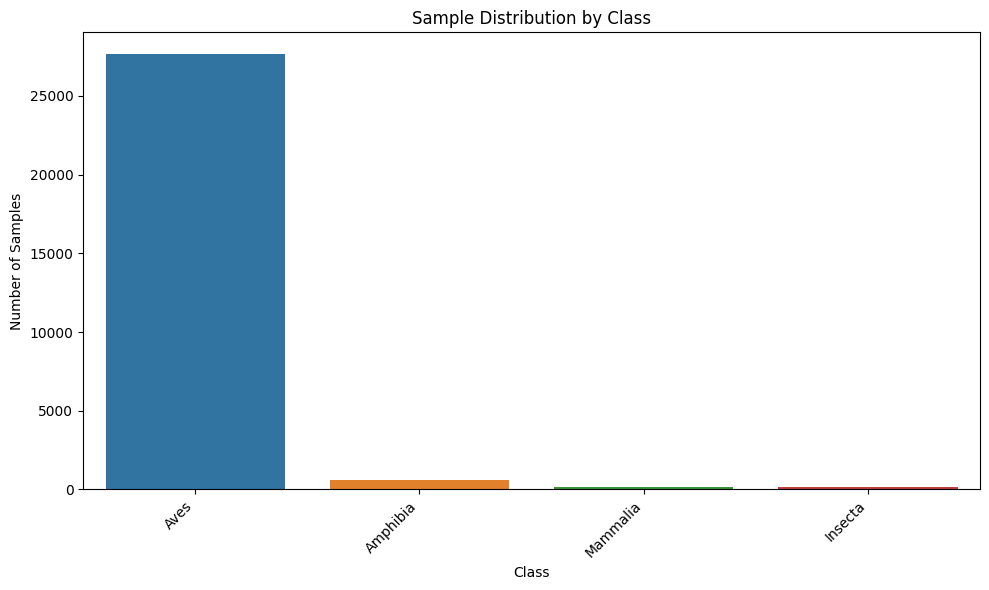

In [7]:
# Class-wise samples count ko plot karte hain
plt.figure(figsize=(10, 6))
sns.countplot(data=working_df, x='class', order=working_df['class'].value_counts().index)

# Plot ki customization (optional)
plt.title('Sample Distribution by Class')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('Sample Distribution by Class.png')
# Plot 
plt.show()


## No of samples per label (per specie)

Total classes: 206
Samples per class:
count    206.000000
mean     138.660194
std      169.177583
min        2.000000
25%       19.000000
50%       80.500000
75%      182.750000
max      990.000000
Name: count, dtype: float64


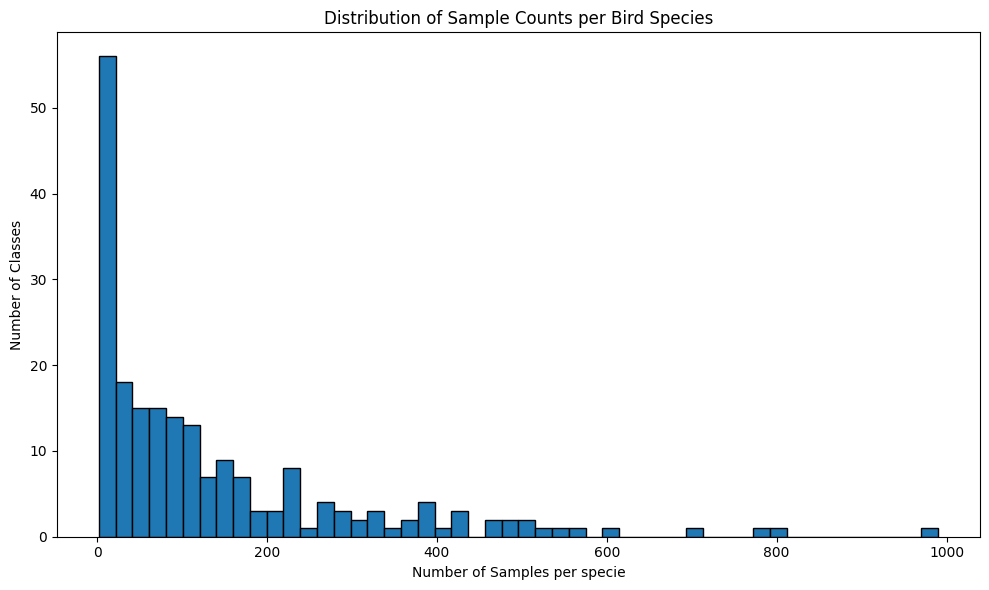

In [8]:
# Count total unique classes
print("Total classes:", working_df['primary_label'].nunique())

# Count samples per class
print("Samples per class:")
print(working_df['primary_label'].value_counts().describe())

# Visualize class imbalance
plt.figure(figsize=(10, 6))
working_df['primary_label'].value_counts().plot(kind='hist', bins=50, edgecolor='black')
plt.title('Distribution of Sample Counts per Bird Species')
plt.xlabel('Number of Samples per specie')
plt.ylabel('Number of Classes')
plt.tight_layout()

# Save the plot
plt.savefig('class_distribution_histogram.png')
plt.show()

## What This Means:
**📉 Highly Imbalanced Dataset:**
- Majority of the classes have very few samples (likely <100).
- A small number of classes have hundreds of samples.

**⚠️ Long Tail Problem:**
- This is a classic long-tail distribution, common in wildlife sound datasets.
- It means: few species are over-represented; many are under-represented.



###  Rating EDA working_df

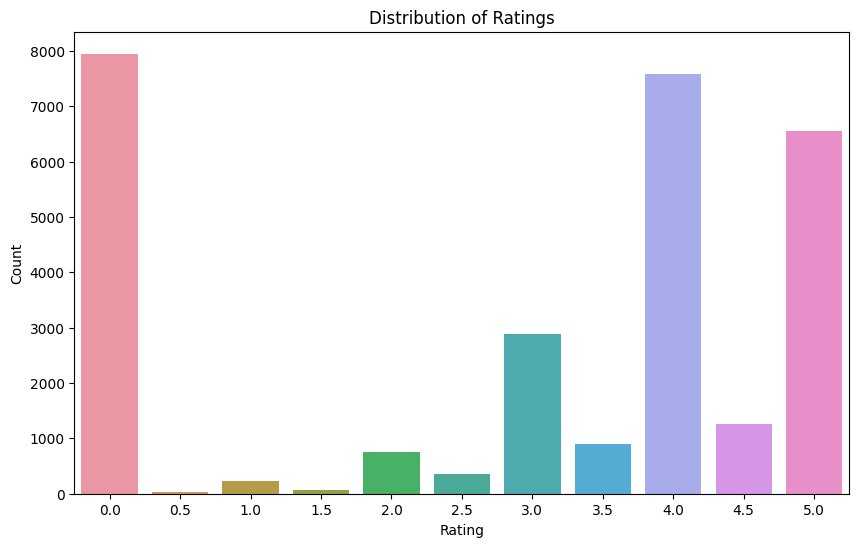

In [9]:
plt.figure(figsize=(10, 6))
sns.countplot(x='rating', data=working_df)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.grid(False)
plt.savefig('Distribution of Ratings.png')
plt.show()


### Average and Median Rating

In [10]:
print(f"Average rating: {working_df['rating'].mean():.2f}")
print(f"Median rating: {working_df['rating'].median()}")

Average rating: 2.92
Median rating: 4.0


### Rating by Class 

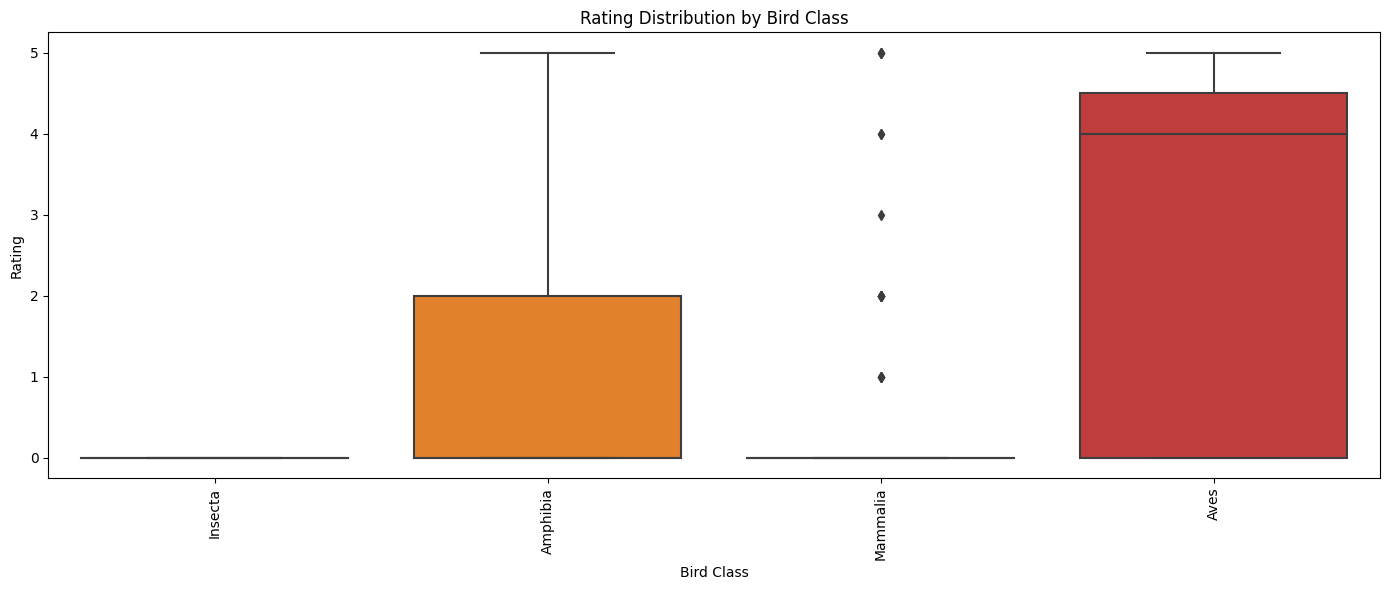

In [11]:
plt.figure(figsize=(14, 6))
sns.boxplot(x='class', y='rating', data=working_df)
plt.title('Rating Distribution by Bird Class')
plt.xlabel('Bird Class')
plt.ylabel('Rating')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('Rating Distribution by Bird Class.png')
plt.show()

## 📊 Basic EDA Insights

- **Total Samples**: 28,564, with the majority of samples belonging to the `Aves` class (27,648), and much fewer in the other classes (`Amphibia`, `Mammalia`, and `Insecta`).

- **Ratings Distribution**: Ratings range from `0.0` to `5.0`, with a mean rating of `2.92` and a standard deviation of `1.96`, indicating varied sample quality. There are no missing values in any of the columns, ensuring a clean dataset.


## Distribution of Target Labels

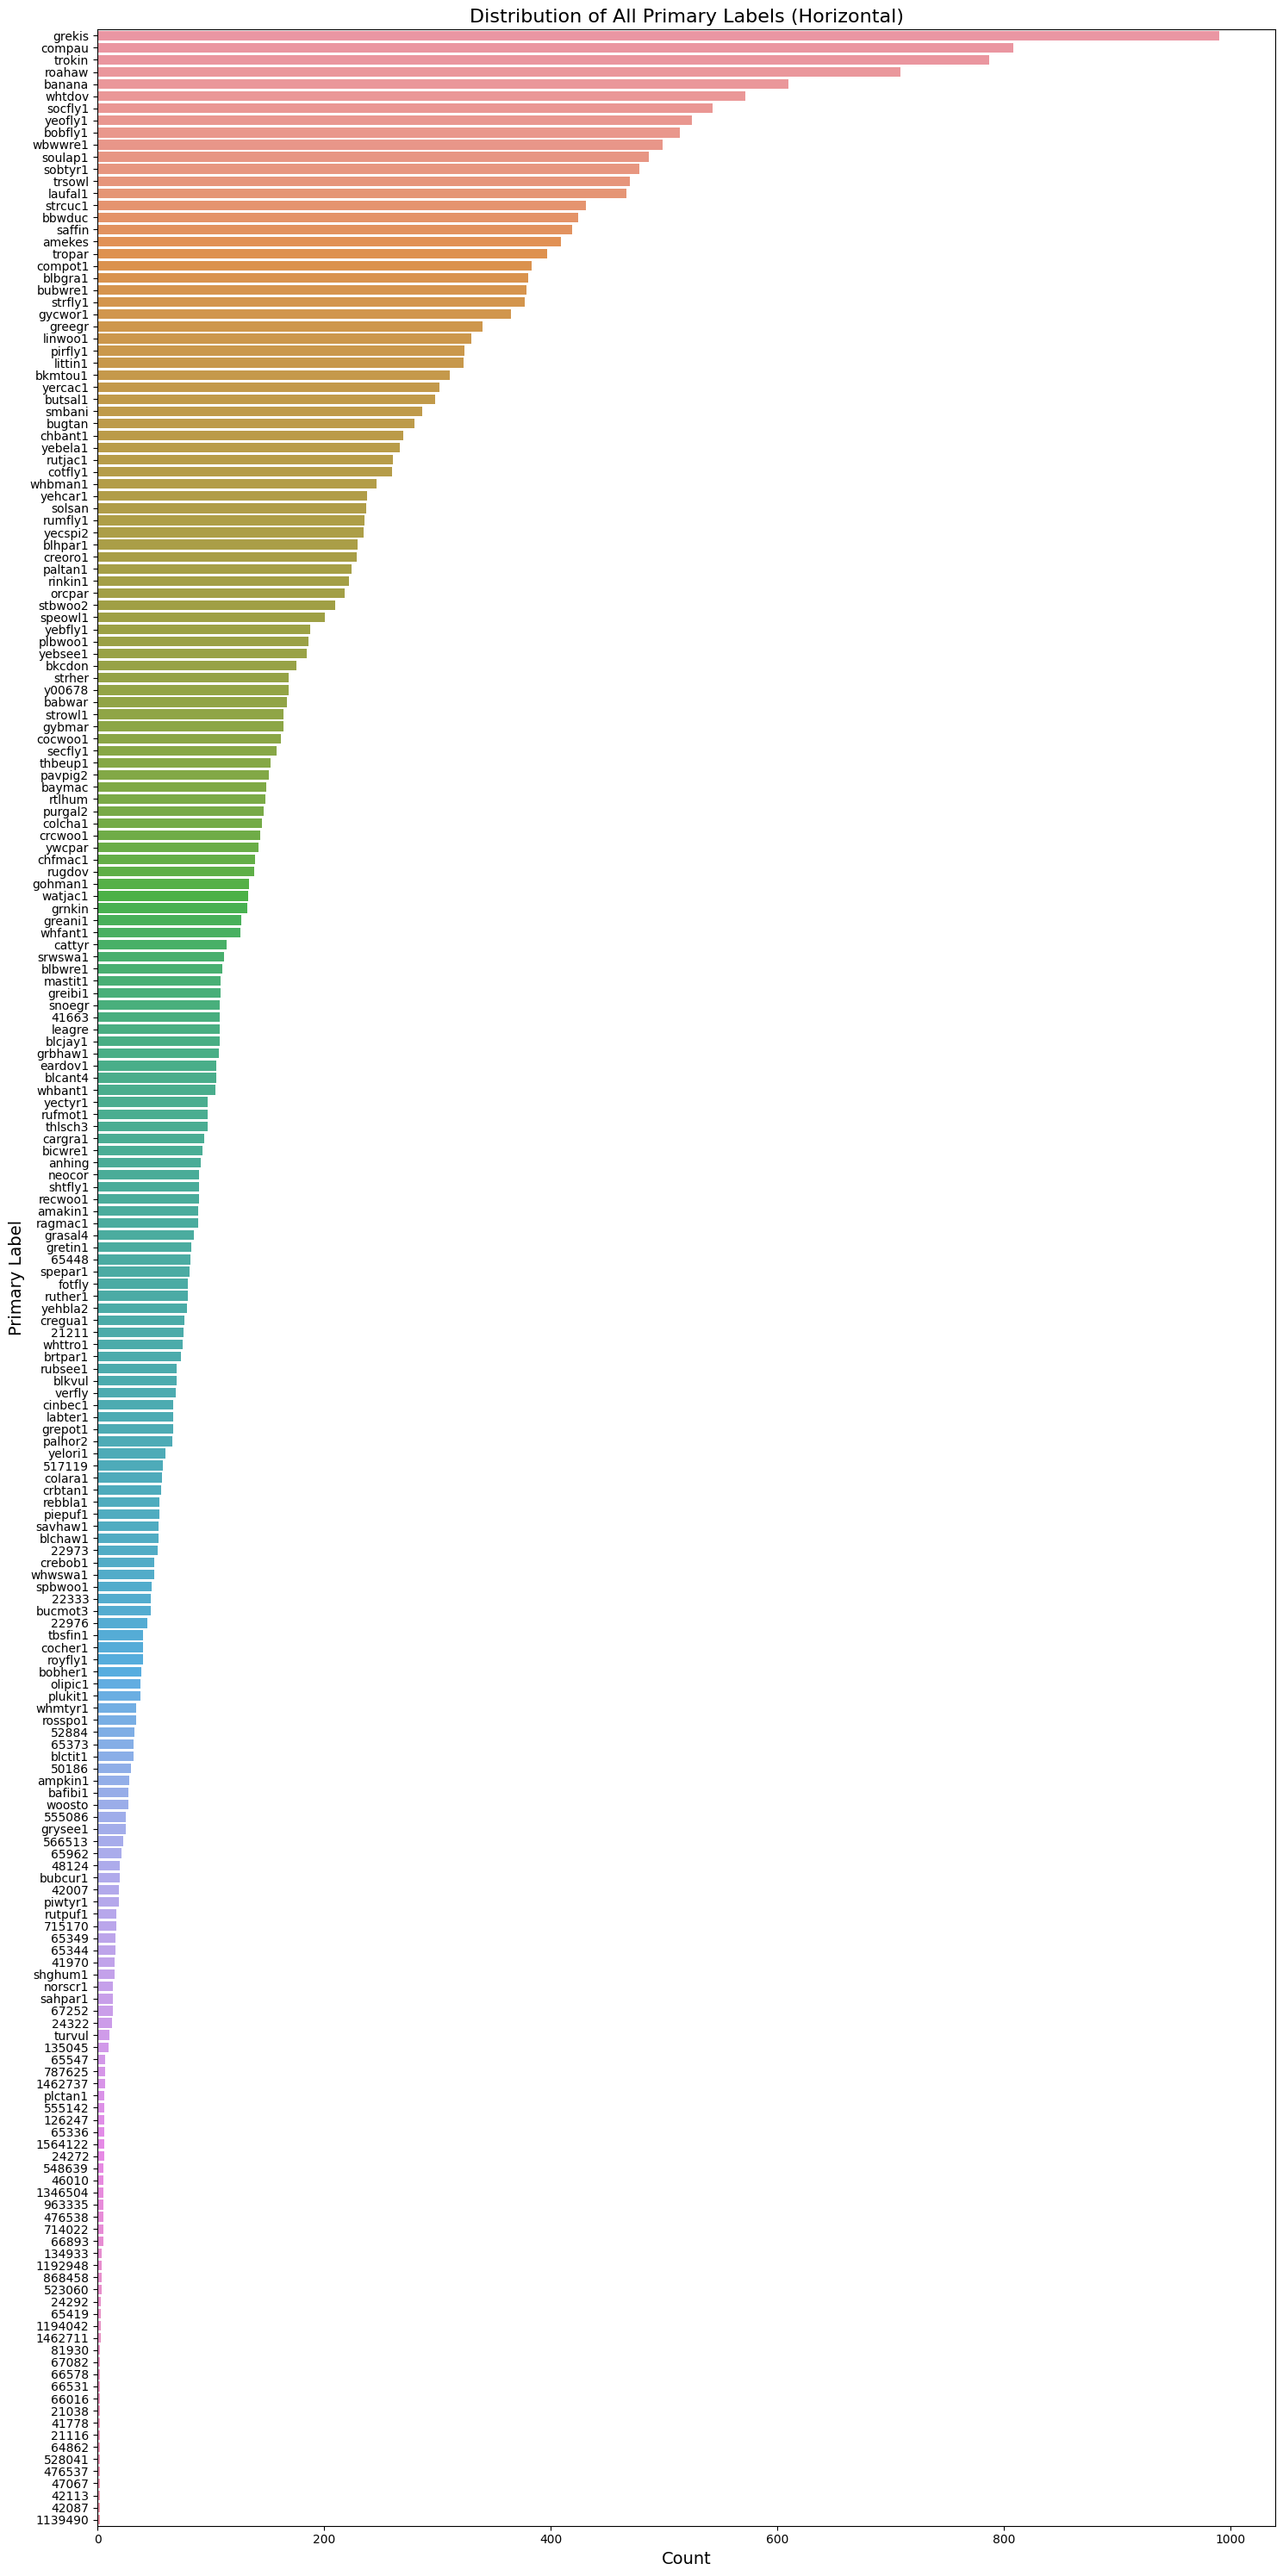

Most common species: grekis with 990 samples
Least common species: 1139490 with 2 samples
Imbalance ratio (most common / least common): 495.00


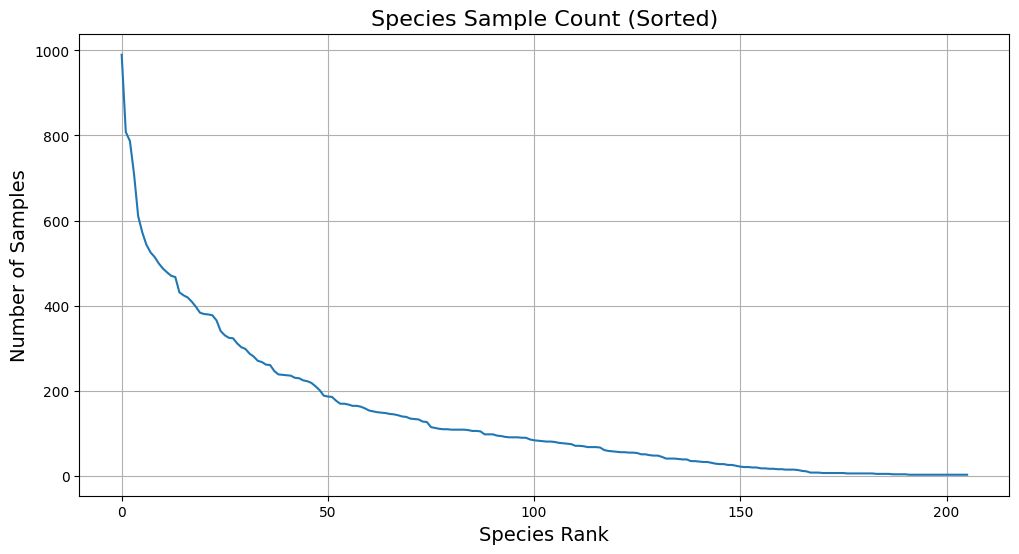

Number of rare classes (<10 samples): 39
Rare classes: {'65547': 7, '787625': 7, '1462737': 7, 'plctan1': 6, '555142': 6, '126247': 6, '65336': 6, '1564122': 6, '24272': 6, '548639': 5, '46010': 5, '1346504': 5, '963335': 5, '476538': 5, '714022': 5, '66893': 5, '134933': 4, '1192948': 4, '868458': 4, '523060': 4, '24292': 3, '65419': 3, '1194042': 3, '1462711': 3, '81930': 2, '67082': 2, '66578': 2, '66531': 2, '66016': 2, '21038': 2, '41778': 2, '21116': 2, '64862': 2, '528041': 2, '476537': 2, '47067': 2, '42113': 2, '42087': 2, '1139490': 2}


In [12]:
# Count primary labels in working_df
primary_label_counts = working_df['primary_label'].value_counts()

# Plot distribution of all primary labels (horizontal bar plot)
plt.figure(figsize=(15, 30))  # Adjusting the figure size to fit all labels
ax = sns.barplot(y=primary_label_counts.index, x=primary_label_counts.values)
plt.title('Distribution of All Primary Labels (Horizontal)', fontsize=16)
plt.ylabel('Primary Label', fontsize=14)
plt.xlabel('Count', fontsize=14)
plt.tight_layout()
plt.show()

# Show statistics about class imbalance
print(f"Most common species: {primary_label_counts.index[0]} with {primary_label_counts.values[0]} samples")
print(f"Least common species: {primary_label_counts.index[-1]} with {primary_label_counts.values[-1]} samples")
print(f"Imbalance ratio (most common / least common): {primary_label_counts.values[0] / primary_label_counts.values[-1]:.2f}")

# Analyze the long tail
plt.figure(figsize=(12, 6))
plt.plot(range(len(primary_label_counts)), sorted(primary_label_counts.values, reverse=True))
plt.title('Species Sample Count (Sorted)', fontsize=16)
plt.xlabel('Species Rank', fontsize=14)
plt.ylabel('Number of Samples', fontsize=14)
plt.grid(True)
plt.show()

# Determine rare classes (< 10 samples)
rare_classes = primary_label_counts[primary_label_counts < 10]
print(f"Number of rare classes (<10 samples): {len(rare_classes)}")
print(f"Rare classes: {rare_classes.to_dict()}")


In [13]:
display(working_df)

primary_label  rating               filename  target  \
0           1139490     0.0   1139490/CSA36385.ogg       0   
1           1139490     0.0   1139490/CSA36389.ogg       0   
2           1192948     0.0   1192948/CSA36358.ogg       1   
3           1192948     0.0   1192948/CSA36366.ogg       1   
4           1192948     0.0   1192948/CSA36373.ogg       1   
...             ...     ...                    ...     ...   
28559        ywcpar     0.0   ywcpar/iNat77392.ogg     205   
28560        ywcpar     0.0   ywcpar/iNat78624.ogg     205   
28561        ywcpar     0.0  ywcpar/iNat789234.ogg     205   
28562        ywcpar     0.0  ywcpar/iNat819873.ogg     205   
28563        ywcpar     0.0  ywcpar/iNat922688.ogg     205   

                                                filepath         samplename  \
0      /kaggle/input/birdclef-2025/train_audio/113949...   1139490-CSA36385   
1      /kaggle/input/birdclef-2025/train_audio/113949...   1139490-CSA36389   
2      /kaggle/input/birdclef-2025/train_audio/119294...   1192948-CSA36358   
3      /kaggle/input/birdclef-2025/train_audio/119294...   1192948-CSA36366   
4      /kaggle/input/birdclef-2025/train_audio/119294...   1192948-CSA36373   
...                                                  ...                ...   
28559  /kaggle/input/birdclef-2025/train_audio/ywcpar...   ywcpar-iNat77392   
28560  /kaggle/input/birdclef-2025/train_audio/ywcpar...   ywcpar-iNat78624   
28561  /kaggle/input/birdclef-2025/train_audio/ywcpar...  ywcpar-iNat789234   
28562  /kaggle/input/birdclef-2025/train_audio/ywcpar...  ywcpar-iNat819873   
28563  /kaggle/input/birdclef-2025/train_audio/ywcpar...  ywcpar-iNat922688   

         class  
0      Insecta  
1      Insecta  
2      Insecta  
3      Insecta  
4      Insecta  
...        ...  
28559     Aves  
28560     Aves  
28561     Aves  
28562     Aves  
28563     Aves  

[28564 rows x 7 columns]

## Secondary labels 

In [14]:
import ast

# Step 1: Define function to parse string to list
def parse_secondary_labels(label_str):
    if pd.isna(label_str):
        return []
    try:
        return ast.literal_eval(label_str)
    except:
        return []

# Step 2: Parse 'secondary_labels' column in train_df
train_df['parsed_secondary_labels'] = train_df['secondary_labels'].apply(parse_secondary_labels)

# Step 3: Merge parsed secondary labels into working_df
working_df = working_df.merge(
    train_df[['filename', 'parsed_secondary_labels']],
    on='filename',
    how='left'
)

# Step 4: Rename for clarity
working_df.rename(columns={'parsed_secondary_labels': 'secondary_labels'}, inplace=True)

# Step 5: Create unique ID mapping for secondary labels
secondary_label_list = sorted(set([label for sublist in working_df['secondary_labels'] for label in sublist]))
secondary_label2id = {label: idx for idx, label in enumerate(secondary_label_list)}
id2secondary_label = {idx: label for label, idx in secondary_label2id.items()}

# Step 6: Map secondary labels to ID targets
working_df['secondary_target'] = working_df['secondary_labels'].apply(
    lambda x: [secondary_label2id.get(label, -1) for label in x]
)

# Step 7: Check stats
has_secondary = working_df['secondary_labels'].apply(lambda x: len(x) > 0)
print(f"\n✅ Recordings with secondary labels: {has_secondary.sum()} ({has_secondary.sum()/len(working_df)*100:.2f}%)")



✅ Recordings with secondary labels: 28539 (99.91%)


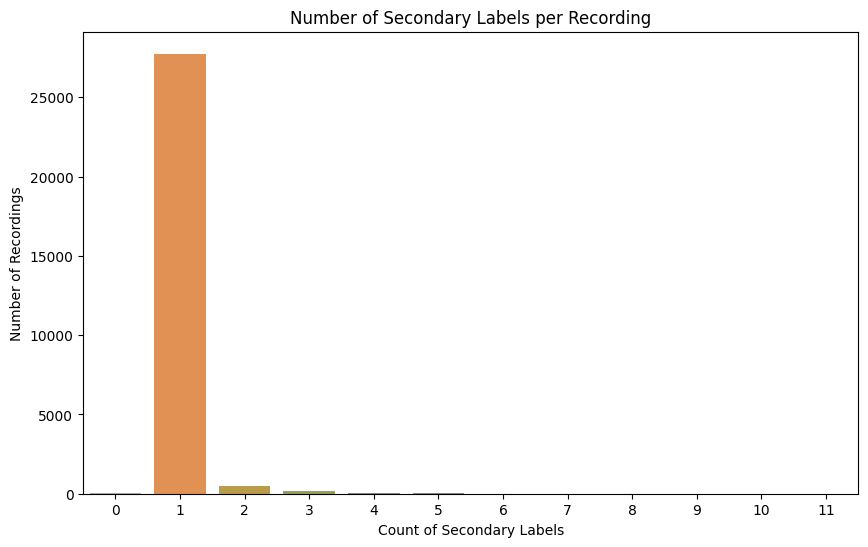

In [15]:
plt.figure(figsize=(10, 6))
sns.countplot(x=working_df['secondary_labels'].apply(len))
plt.title('Number of Secondary Labels per Recording')
plt.xlabel('Count of Secondary Labels')
plt.ylabel('Number of Recordings')
plt.savefig('Number of Secondary Labels per Recording.png')
plt.show()


In [16]:
display(working_df.sample(1))

primary_label  rating              filename  target  \
24658       wbwwre1     5.0  wbwwre1/XC528993.ogg     185   

                                                filepath        samplename  \
24658  /kaggle/input/birdclef-2025/train_audio/wbwwre...  wbwwre1-XC528993   

      class secondary_labels secondary_target  
24658  Aves               []              [0]

### AudiO Duration Analysis

Calculating durations for 28564 audio files...


  0%|          | 0/28564 [00:00<?, ?it/s]

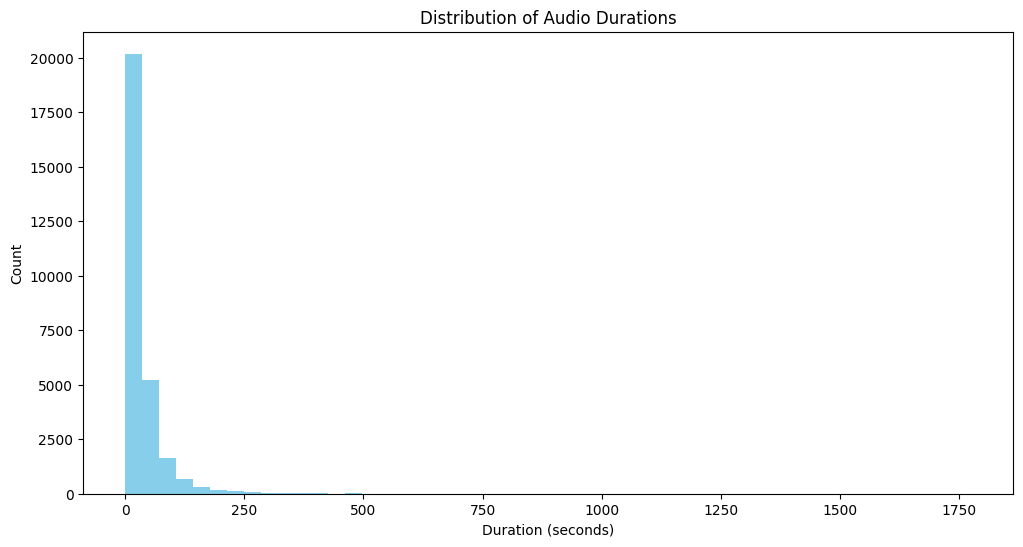

Duration stats:
Mean: 35.35 sec
Median: 20.98 sec
Min: 0.54 sec
Max: 1774.39 sec
Very short recordings (<1s): 24 (0.08%)
Long recordings (>60s): 4282 (14.99%)


In [17]:
# Function to get audio duration
def get_audio_duration(file_path, sr=32000):  # SAMPLE_RATE jo b rakhna ho
    try:
        audio, _ = librosa.load(file_path, sr=sr)
        return len(audio) / sr
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None

# Calculate durations for all files in working_df (or sample agar zyada ho)
durations = []
filepaths = working_df['filepath'].tolist()

print(f"Calculating durations for {len(filepaths)} audio files...")

for fp in tqdm(filepaths):
    duration = get_audio_duration(fp)
    if duration is not None:
        durations.append(duration)
    else:
        durations.append(np.nan)  # handle missing if error

# Add durations to working_df
working_df['duration'] = durations

# Plot duration distribution
plt.figure(figsize=(12, 6))
plt.hist(working_df['duration'].dropna(), bins=50, color='skyblue')
plt.title('Distribution of Audio Durations')
plt.xlabel('Duration (seconds)')
plt.ylabel('Count')
plt.savefig("Distribution of Audio Durations.png")
plt.show()

# Print some stats
print(f"Duration stats:")
print(f"Mean: {np.nanmean(working_df['duration']):.2f} sec")
print(f"Median: {np.nanmedian(working_df['duration']):.2f} sec")
print(f"Min: {np.nanmin(working_df['duration']):.2f} sec")
print(f"Max: {np.nanmax(working_df['duration']):.2f} sec")

# Check short and long recordings count
short_count = (working_df['duration'] < 1).sum()
long_count = (working_df['duration'] > 60).sum()
total = working_df.shape[0]

print(f"Very short recordings (<1s): {short_count} ({short_count/total*100:.2f}%)")
print(f"Long recordings (>60s): {long_count} ({long_count/total*100:.2f}%)")


### WavePlot

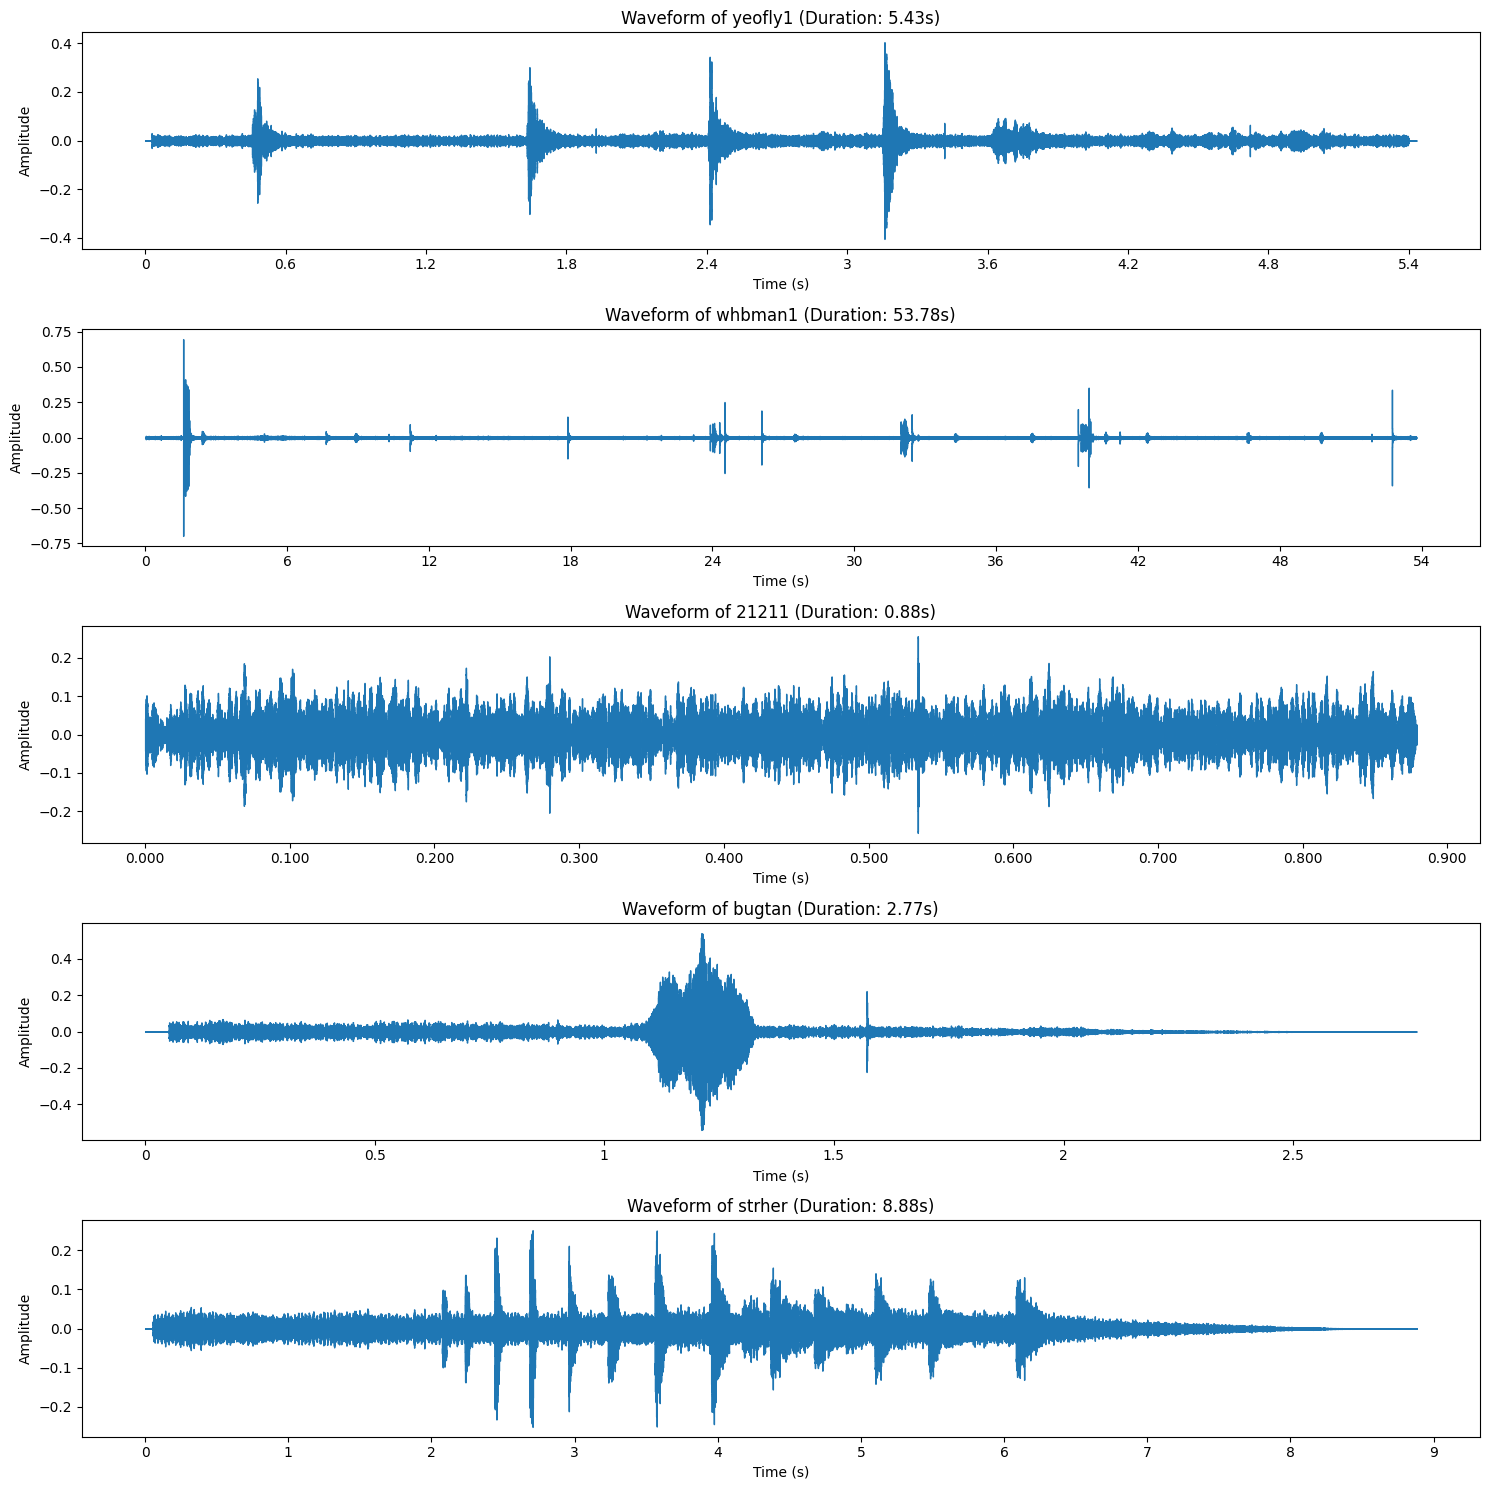

In [18]:
# Number of waveforms to plot
num_samples = 5

# Randomly sample files from working_df
sampled_df = working_df.sample(n=num_samples, random_state=42).reset_index(drop=True)

plt.figure(figsize=(15, 3 * num_samples))

for i, row in sampled_df.iterrows():
    file_path = row['filepath']
    label = row['primary_label']
    duration = row['duration']

    # Load audio
    audio, sr = librosa.load(file_path, sr=None)  # Use native sample rate

    plt.subplot(num_samples, 1, i+1)
    librosa.display.waveshow(audio, sr=sr)
    plt.title(f"Waveform of {label} (Duration: {duration:.2f}s)")
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

plt.tight_layout()

# Save the figure before showing
plt.savefig('waveform_samples.png', dpi=300)

plt.show()


### convert Audio into Spectrum

In [19]:
# Function jo audio ko mel spectrogram me conversion
def audio2melspec(audio_data):
    # if Nan usko remove krty hain
    if np.isnan(audio_data).any():
        mean_val = np.nanmean(audio_data)
        audio_data = np.nan_to_num(audio_data, nan=mean_val)

    # Mel spectrogram 
    mel = librosa.feature.melspectrogram(
        y=audio_data,
        sr=config.FS,
        n_fft=config.N_FFT,
        hop_length=config.HOP_LENGTH,
        n_mels=config.N_MELS,
        fmin=config.FMIN,
        fmax=config.FMAX,
        power=2.0
    )

    # Usko decibels me conversion
    mel_db = librosa.power_to_db(mel, ref=np.max)

    # Normalization
    mel_db = (mel_db - mel_db.min()) / (mel_db.max() - mel_db.min() + 1e-8)

    return mel_db


In [20]:
def prepare_audio(audio, target_len):
    #if audio choti ho to usko repeat karo
    while len(audio) < target_len:
        audio = np.concatenate([audio, audio])

    # Center se target length ka audio
    start = max(0, len(audio) // 2 - target_len // 2)
    audio = audio[start:start + target_len]

    # if audio bhi choti ho to padding
    if len(audio) < target_len:
        audio = np.pad(audio, (0, target_len - len(audio)), mode='constant')
    
    return audio


In [21]:
print("🔄 lets start audio processing...")
start_time = time.time()

all_bird_data = {}
errors = []
target_len = int(config.TARGET_DURATION * config.FS)

for i, row in tqdm(working_df.iterrows(), total=total_samples):
    if config.N_MAX and i >= config.N_MAX:
        break
    try:
        # Load karo audio
        audio, _ = librosa.load(row.filepath, sr=config.FS)

        # Audio ko prepare karo
        audio = prepare_audio(audio, target_len)

        # Mel spectrogram banao
        mel = audio2melspec(audio)

        # Agar shape match nahi karta to resize karo
        if mel.shape != config.TARGET_SHAPE:
            mel = cv2.resize(mel, config.TARGET_SHAPE)

        # Dictionary me save karo
        all_bird_data[row.samplename] = mel.astype(np.float32)

    except Exception as e:
        print(f"❌ Error in {row.filepath}")
        errors.append((row.filepath, str(e)))

end_time = time.time()

print(f"✅ Done in {end_time - start_time:.1f} seconds")
print(f"🟢 Processed: {len(all_bird_data)} files")
print(f"🔴 Failed: {len(errors)} files")

print("saving the numpy file")
# Save the dictionary as a NumPy compressed file (.npz)
np.savez_compressed('all_bird_data.npz', **all_bird_data)

print("✅ Data saved as all_bird_data.npz")

🔄 lets start audio processing...


  0%|          | 0/28564 [00:00<?, ?it/s]

✅ Done in 1632.7 seconds
🟢 Processed: 28564 files
🔴 Failed: 0 files
saving the numpy file
✅ Data saved as all_bird_data.npz


In [22]:
working_df.to_csv('working_df.csv', index=False)
print("Saved the workin df as csv")


Saved the workin df as csv


### 🔍 Steps We Followed:

| 🧠 Concept Mentioned             | ✅ Implementation                                       |
|----------------------------------|-----------------------------------------------------------------|
| 🎧 **Audio Preprocessing**       | `librosa.load`, padding if short, centering the audio clip     |
| 🔎 **Spectrogram Generation**    | `librosa.feature.melspectrogram()` for mel-scale spectrogram   |
| ⚙️ **Tuned FFT Parameters**      | `n_fft`, `hop_length`, `fmin`, `fmax` from `config`            |
| 🎚️ **Amplitude Normalization**  | `librosa.power_to_db`, then normalized to [0, 1] range         |
| 🎯 **Optimization for Accuracy** | Centering the audio & resizing spectrograms to a fixed shape  |


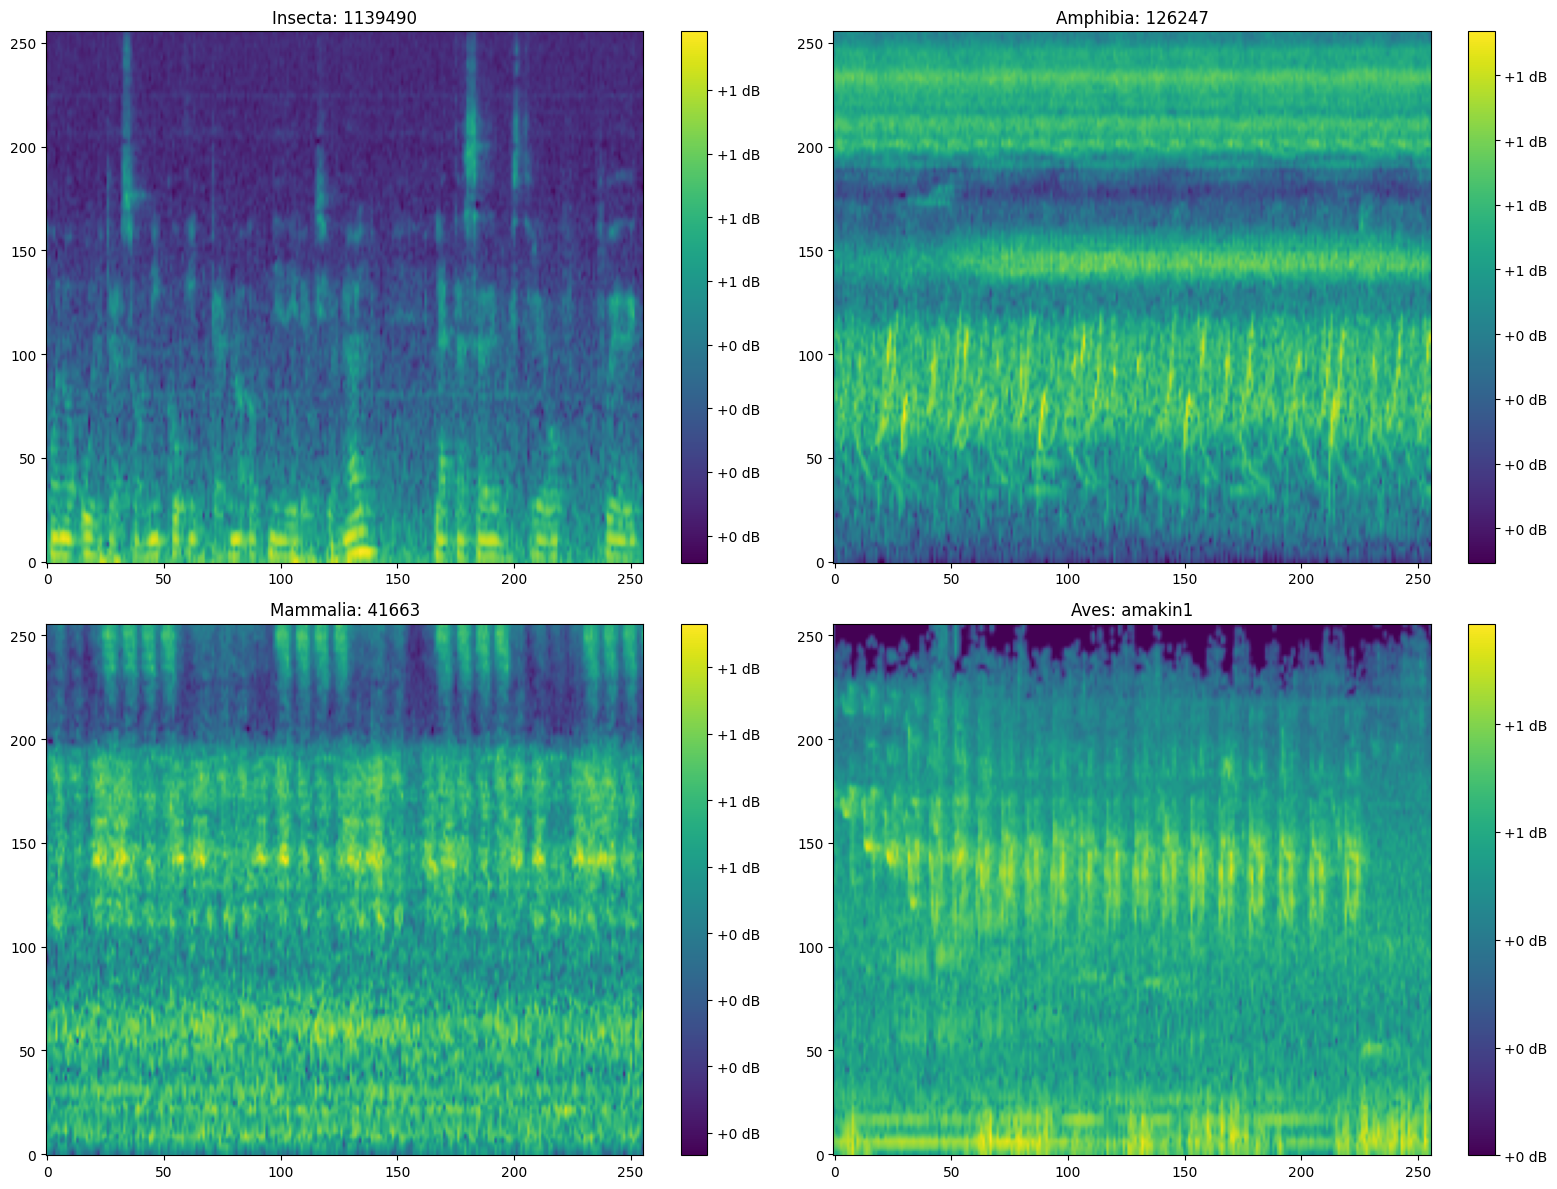

In [23]:
# Simple list to store sample data and a set to track displayed classes
samples = []
displayed_classes = set()

# Limit the number of samples to display
max_samples = 4

# Iterate through the dataframe
for i, row in working_df.iterrows():
    if len(samples) >= max_samples:  # Stop once we've selected enough samples
        break

    if row['samplename'] in all_bird_data:
        # If class not already displayed, add sample
        if row['class'] not in displayed_classes:
            samples.append((row['samplename'], row['class'], row['primary_label']))
            displayed_classes.add(row['class'])

# Plotting the spectrograms
if samples:
    plt.figure(figsize=(16, 12))
    
    # Display the spectrogram for each sample
    for i, (samplename, class_name, species) in enumerate(samples):
        plt.subplot(2, 2, i+1)  # Create 2x2 grid
        plt.imshow(all_bird_data[samplename], aspect='auto', origin='lower', cmap='viridis')
        plt.title(f"{class_name}: {species}")
        plt.colorbar(format='%+2.0f dB')
    
    plt.tight_layout()
    plt.savefig('melspec_examples.png')  # Save plot as an image
    plt.show()  # Display the plot


## 🖼️ Insights from Spectrogram Samples by Class

| **Class**        | **Observation**                                                                 | **Interpretation**                                                       | **Suggestion**                                                                 |
|------------------|----------------------------------------------------------------------------------|--------------------------------------------------------------------------|--------------------------------------------------------------------------------|
| 🐜 Insecta        | Energy is mostly in **lower frequencies** with scattered high-frequency spikes  | Likely due to insect wing flapping or rhythmic chirping                  | Time-frequency patterns could be useful for classification                    |
| 🐸 Amphibia       | Strong horizontal bands (harmonics) in **mid-frequency** range                  | Indicates tonal, repetitive calls like frog croaks                       | Harmonic structure can be extracted using MFCCs or spectral contrast features |
| 🐶 Mammalia       | Broad frequency range with **dense energy** throughout                          | Could be due to a mix of environmental noise and mammalian vocalization  | May benefit from noise filtering or background separation                     |
| 🐦 Aves (amalkan) | Repeating vertical stripes suggesting **repetitive bird calls**                 | Likely sharp, short chirps or tweets with structured timing              | Use temporal rhythm and pitch variation features                              |


###  Spectrogram Shapes and Stats

In [24]:
shapes = [mel.shape for mel in all_bird_data.values()]
unique_shapes = set(shapes)
print(f"Unique shapes: {unique_shapes}")


Unique shapes: {(256, 256)}


###  Sample Visualizations

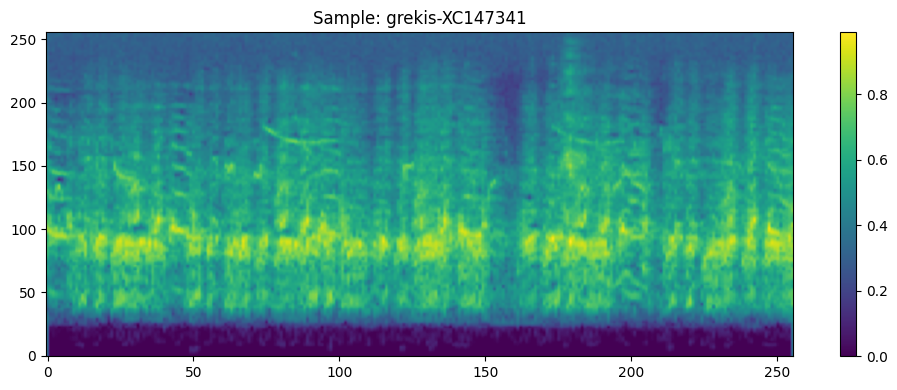

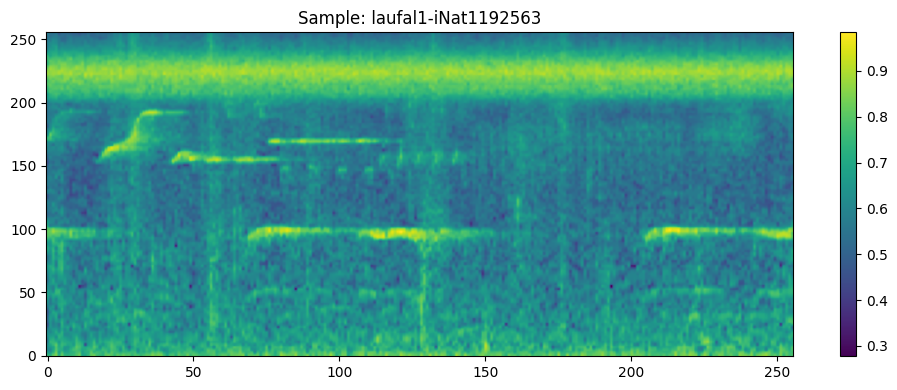

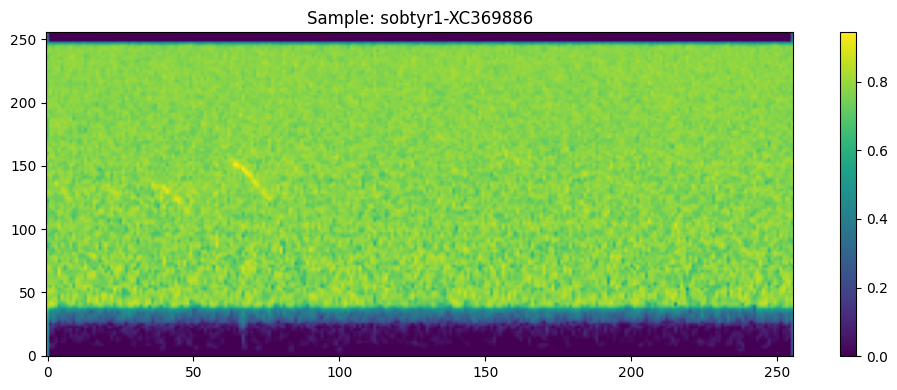

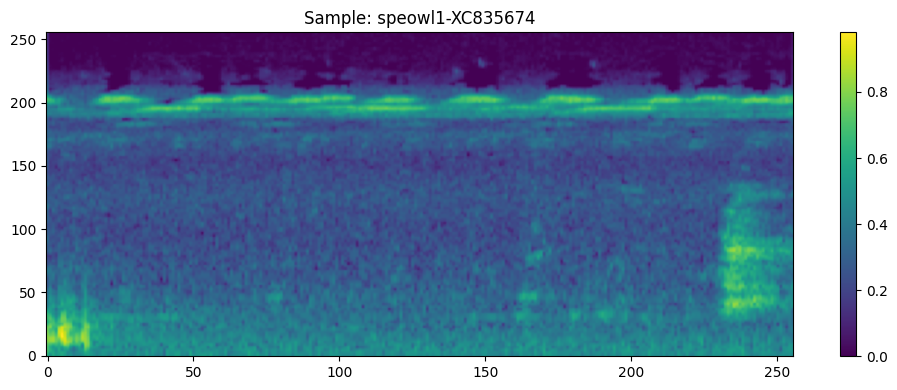

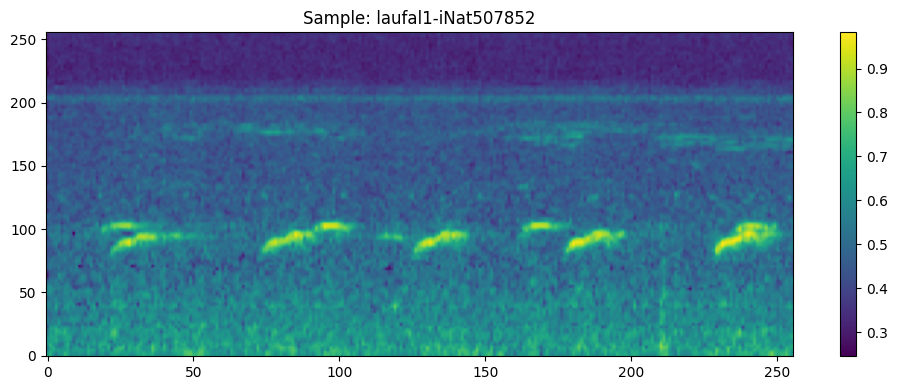

In [25]:
# Create directory to save plots if it doesn't exist
os.makedirs("melspec_samples", exist_ok=True)

sample_keys = random.sample(list(all_bird_data.keys()), 5)

for key in sample_keys:
    plt.figure(figsize=(10, 4))
    plt.imshow(all_bird_data[key], aspect='auto', origin='lower', cmap='viridis')
    plt.title(f"Sample: {key}")
    plt.colorbar()
    plt.tight_layout()
    
    # Save each image with a unique filename
    filename = f"melspec_samples/{key.replace('/', '_').replace(':', '_')}.png"
    plt.savefig(filename)
    plt.show()


## 🔎 General Insights

| **Aspect**         | **Observation**                                                  | **Suggestion**                                                      |
|--------------------|------------------------------------------------------------------|----------------------------------------------------------------------|
| Variation          | Different samples have different frequency-energy patterns       | dataset diverse hai — good for generalization                 |
| Clarity            | Kuch spectrograms highly structured hain (e.g., babbly1, babbly3) | Ideal for CNNs                                                      |
| Noise              | Kuch samples noisy ya diffuse hain (e.g., compae, orwrec3)       | Try spectrogram denoising, filtering                                |
| Frequency bands    | Kuch samples mid-to-high frequencies mein dominate kar rahe hain | Band-wise feature extraction useful ho sakta hai                    |
| Pattern detection  | Visual patterns clearly dikh rahe hain                           | Feature-based ya image-based deep learning (CNNs) recommend         |


### Intensity Distribution Analysis

In [26]:
all_values = np.concatenate([mel.flatten() for mel in all_bird_data.values()])
# Save the plot directly without specifying the filename variable
plt.hist(all_values, bins=50, color='skyblue')
plt.title("Distribution of Mel Spectrogram Values")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.grid(True)

# Save the plot directly
plt.savefig("mel_spectrogram_distribution.png")
plt.close()


## 📊 Insights from Distribution of Mel Spectrogram Values

| **Observation**               | **Interpretation**                                                      | **Suggestion**                                                        |
|-------------------------------|-------------------------------------------------------------------------|------------------------------------------------------------------------|
| Bell-shaped curve             | Values ka distribution roughly Gaussian lagta hai (excluding 0 spike)  | Good for models like CNNs or RNNs, especially if normalized           |
| High zero values (left spike) | A significant portion of the data is zero-valued                        | Could be due to silence, zero-padding, or background noise            |
| Peak around 0.4–0.5           | Most non-zero values fall in mid-intensity range                        | Ideal normalization already seems applied                             |
| Low tail beyond 0.8           | Few high-energy components                                              | Spectrograms are not dominated by loud sounds                         |


### Duration / Energy Distribution

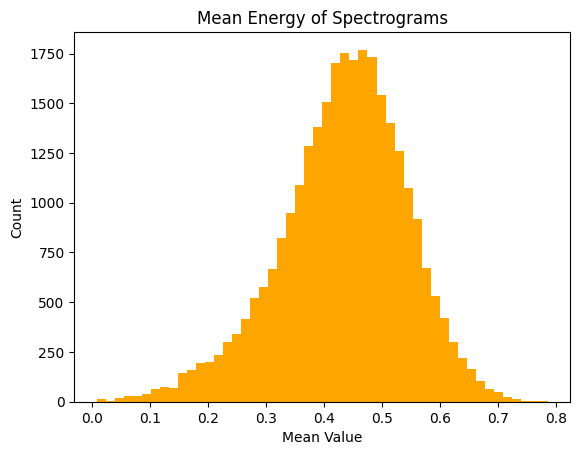

In [27]:
energies = [np.mean(mel) for mel in all_bird_data.values()]
plt.hist(energies, bins=50, color='orange')
plt.title("Mean Energy of Spectrograms")
plt.xlabel("Mean Value")
plt.ylabel("Count")
plt.savefig("Mean Energy of Spectrograms.png")
plt.show()


## 📊 Insights from Mean Energy of Spectrograms

| **Observation**                  | **Interpretation**                                                         | **Suggestion**                                                         |
|----------------------------------|-----------------------------------------------------------------------------|-------------------------------------------------------------------------|
| 🔔 Bell-shaped distribution       | Mean energy values are normally distributed (Gaussian-like)                | Suitable for ML models; may benefit from standardization if needed     |
| 🟠 Left-side spike near 0         | Many spectrograms have very low or zero energy                             | Investigate silence, padding, or low-intensity segments                |
| 🔼 Peak between 0.4 and 0.5       | Majority of spectrograms have mid-range energy                             | Indicates consistent preprocessing or real-world sound dynamics        |
| 🔽 Sparse tail after 0.7–0.8      | Very few samples have high mean energy                                     | Suggests lack of very loud sounds; may not need log-scaling            |
| 📉 Symmetry of distribution       | Balanced distribution without skew                                         | Implies stable data input for training purposes                        |


## ✅ Conclusion

In this notebook, we performed a detailed Exploratory Data Analysis (EDA) on the spectrogram-based audio dataset. We explored:

- Class-wise spectrogram patterns and what they reveal about the audio signals.
- Distribution of spectrogram values and their suitability for deep learning models.
- Identified noise, silence, and structure — crucial for preprocessing and augmentation.

The dataset shows good diversity, clear frequency patterns, and consistent energy levels — all signs of a high-quality input pipeline.

---

## 📦 What’s Next?

We have saved the cleaned and labeled `.npz` files. In the **next notebook**, we will:
- Extract features (e.g., MFCC, Log-Mel)
- Apply data augmentation for generalization
- Build and train deep learning models (e.g., CNNs or CRNNs)
- Evaluate performance using proper metrics

Stay tuned for the **Training Notebook**! 🚀

---

#### 📘 Made with ❤️  
If you found this helpful, don’t forget to **like** and **share** it with others!  
Let's keep learning and building together. 💡🔊

*******************
********************